In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from IPython.display import clear_output
from pyelq.coordinate_system import ENU
from pyelq.dispersion_model.finite_volume import FiniteVolume, FiniteVolumeDimension
from pyelq.gas_species import CH4
from pyelq.meteorology import Meteorology
from pyelq.meteorology_windfield import MeteorologyWindfield, SiteLayout
from pyelq.source_map import SourceMap


# How to use finite volume dispersion model in pyELQ
This example is intended to provide an overview on how to use the finite volume dispersion model in pyELQ to do a forward simulation in the presence of obstacle to calculate the concentration.

## Basic Setup
Basic setup of site limits and time

In [3]:
time_axis = pd.array(
    pd.date_range(start="2024-01-01 08:00:00", end="2024-01-01 08:30:00", freq="10s"), dtype="datetime64[ns]"
)
nof_observations = time_axis.size
reference_latitude = 0
reference_longitude = 0
reference_altitude = 0

site_limits = np.array([[0, 30], [0, 30], [0, 10]])

gas_object = CH4()

Next we simulate meteorology observation, i.e., wind speed and wind direction (equivalently u and v components). There is a difference between the generation of the meteorology observations for Gaussian plume (example_basic.ipynb) and Finite Volume which comes down to the the nature of these dispersion models and their sensitivity to wind variablity. **Gaussian Plume** Model assumes steady-state conditions over the averaging period. It works best when wind speed and direction are relatively constant, so using a simple deterministic trend (like a linear change plus Gaussian noise) is sufficient. This keeps the inversion stable and computationally efficient because the model expects smooth meteorological inputs. **Finite Volume** Dispersion Model, on the other hand, solves the time-dependent advection–diffusion equation on a grid. It explicitly tracks how the gas move and mix over time, so the wind field needs to reflect realistic short-term variability and turbulence.


In [4]:
# alternative using a circle of wind directions
met_object = Meteorology()
met_object.time = time_axis

met_object.wind_speed = np.linspace(2.0, 4.0, nof_observations)
met_object.wind_direction = np.linspace(0, 180, nof_observations)
met_object.calculate_uv_from_wind_speed_direction()
met_object.w_component = 0.0 * np.random.normal(size=nof_observations)
met_object.temperature = (273.1 + 15.0) * np.ones_like(met_object.wind_direction)
met_object.pressure = 101.325 * np.ones_like(met_object.wind_direction)

fig_wind = met_object.plot_polar_hist()
fig_wind.update_layout(height=400, margin={"r": 0, "l": 0})
fig_wind.show()

### Defining the Site Layout with Obstacles
Now we define the sitelayout with obstacles. The SiteLayout class represents cylindrical obstacles within the domain, which can influence wind flow and dispersion patterns. These obstacles are defined by their coordinates and radii:

- cylinders_coordinate: An ENU object specifying the east, north positions and height each cylinder relative to a reference latitude, longitude, and altitude.
- cylinders_radius: An array containing the radius of each cylinder.

In this example, two cylindrical obstacles are placed at:
(east=15, north=15, up=5) with radius 1 m
(east=20, north=5, up=7) with radius 2 m

These obstacles will later be used to mask grid cells within their radius, ensuring the dispersion model accounts for blocked regions when computing flow and coupling.


In [5]:
cylinders_coordinate = ENU(ref_latitude=reference_latitude,
                           ref_longitude=reference_longitude,
                           ref_altitude=reference_altitude
                           )
cylinders_coordinate.east = np.array([3, 13])
cylinders_coordinate.north = np.array([19, 2])
cylinders_coordinate.up = np.array([5, 7])
cylinders_radius = np.array([[2, 1]]).T

site_layout = SiteLayout(
    cylinders_coordinate=cylinders_coordinate, cylinders_radius=cylinders_radius
)

## Forward Simulation

### Setting Up 2D Finite Volume Dimensions

For a forward we define a two-dimensional finite volume grid using a custom FiniteVolumeDimension data class. Each dimension—x, y is  characterized by the number of cells, spatial limits, and boundary conditions. For the x and y directions, we use 30 cells each and apply Dirichlet boundary conditions on the external boundaries, which typically fix the variable values at the domain edges. 

In [6]:
dimensions = [
    FiniteVolumeDimension(
        "x",
        number_cells=30,
        limits=site_limits[0],
        external_boundary_type=["dirichlet"],
    ),
    FiniteVolumeDimension(
        "y",
        number_cells=30,
        limits=site_limits[1],
        external_boundary_type=["dirichlet"],
    ),
]

The dimensions are passed into a FiniteVolume object. On initialisation this object defines a grid and works out the neighbourhood and boundary relationships used in the model

In [7]:
diffusion_coefficients = np.array([0.1, 0.1, 1.0])
source_map = SourceMap()
source_map.location  = ENU(
    ref_latitude=reference_latitude, ref_longitude=reference_longitude, ref_altitude=reference_altitude
)
fe_forward = FiniteVolume(
    source_map=source_map,
    dimensions=dimensions,
    diffusion_constants=diffusion_coefficients,
    minimum_contribution=1e-6,
    use_lookup_table=False,
    dt = 0.1,
    site_layout=site_layout
)

The wind field can be computed for a given time_index using the calculate_spatial_wind_field function at the gridcoordinates defined in the fe_forward object.

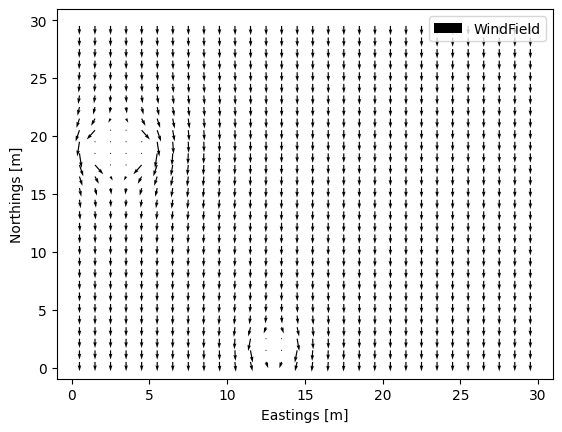

In [ ]:
met_windfield = MeteorologyWindfield(static_wind_field=met_object, site_layout=site_layout)

met_windfield.calculate_spatial_wind_field(grid_coordinates=fe_forward.grid_coordinates, time_index=0)

plt.quiver(
    fe_forward.grid_coordinates.east,
    fe_forward.grid_coordinates.north,
    met_windfield.u_component,
    met_windfield.v_component,
)
plt.xlabel('Eastings [m]')
plt.ylabel('Northings [m]')

plt.title('Wind Field at time=0')

The model is simulated forward by using the compute_forward_matrix function and a forward propogate loop. Emissions are added at a rate of 5.0 kg/hr at the location [15, 10] 

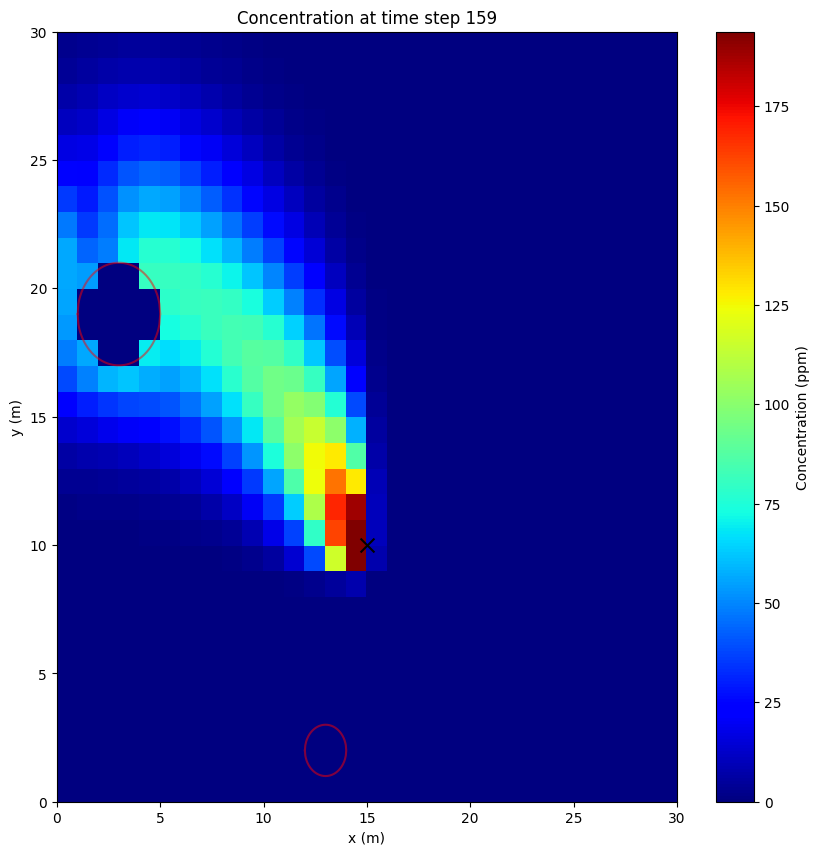

In [ ]:
concentration = np.full((fe_forward.total_number_cells, met_object.nof_observations+1), np.nan)
concentration[:, 0] = 0.0
source_allocation = np.zeros((fe_forward.total_number_cells, 1), dtype=bool)
source_location = np.array([15, 10])
source_rate = 5.0  # kg/hr
tree = cKDTree(
    np.vstack(
        (fe_forward.grid_coordinates.east.flatten(), fe_forward.grid_coordinates.north.flatten())
    ).T
)
_, source_index = tree.query(source_location[:2], k=1)
source_allocation[source_index] = True

x_cylinder = np.linspace(-cylinders_radius, cylinders_radius, 100)
y_cylinder = np.sqrt(cylinders_radius**2 - x_cylinder**2)
y_cylinder = np.concatenate((y_cylinder, -y_cylinder[::-1]))
x_cylinder = np.concatenate((x_cylinder, x_cylinder[::-1]))


for iT in range(met_object.nof_observations):
    met_windfield.calculate_spatial_wind_field(grid_coordinates=fe_forward.grid_coordinates, time_index=iT)

    fe_forward.compute_forward_matrix(met_windfield)

    s_smoothed = source_allocation * source_rate / 3600

    concentration[:, iT + 1] = (fe_forward.dt / fe_forward.cell_volume) * (
        fe_forward.forward_matrix @ concentration[:, iT].reshape(-1, 1) + s_smoothed
    ).flatten()


    if iT % 3 == 0:
        concentration_scaled = concentration[:, iT + 1] * (1e6) / gas_object.gas_density()
        plt.figure(figsize=(10, 10))
        plt.pcolor(
                fe_forward.dimensions[0].cell_centers,
                fe_forward.dimensions[1].cell_centers,
                concentration_scaled.reshape(fe_forward.grid_size).T ,
                cmap="jet",
                shading="auto",
                vmin=np.min(concentration_scaled),
                vmax=0.5 * np.max(concentration_scaled),
            )
        plt.colorbar(label="Concentration (ppm)")
        plt.scatter(
            source_location[0],
            source_location[1],
            color="black",
            label="Source location",
            s=100,
            marker="x",
        )
        for i in range(len(cylinders_coordinate.east)):
                plt.plot(
                    (x_cylinder[:, i, :] + cylinders_coordinate.east[i]),
                    (y_cylinder[:, i, :] + cylinders_coordinate.north[i]),
                    c="red",
                    alpha=0.5,
                )
        plt.title("Concentration at time step {}".format(iT))

        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.show()
        plt.pause(1e-6)
        clear_output(wait=True)